In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (5,3)

In [2]:
PATH_FOLDER = os.getcwd()

In [3]:
def dataclean_nonquote_ftl(oa):
    # any rows where transport mode is ftl and offertype is pool is incorrectly labelled and should be removed
    assert "OFFER_TYPE" in oa.columns
    assert "TRANSPORT_MODE" in oa.columns    
    oa = oa[~((oa["TRANSPORT_MODE"]=="FTL") & (oa["OFFER_TYPE"]!="quote"))]
    return oa

# oa is the csv combining offers and orders on reference numbers
PATH_FILE_oa = PATH_FOLDER + "\\oa.csv"


oa = pd.read_csv(PATH_FILE_oa)
oa = dataclean_nonquote_ftl(oa)

## Datetime Involvement

* In this notebook, it was discovered Thursday has the best chances of getting low rated offers compared to any other business day
    * Rate USD gets log normalized
    * Offers are grouped by their order (reference number), and their (now logged) rate usd is now either: z-scoring (and if so, immediately made boolean by seeing if it is above 0); or percentile; In other words, the offer rates are being rescaled relative to the other offers of the order, not globally.
    * When either of these 2 columns are aggregated by the business day, both will show Thursday as the lowest
    * Statistical hypothesis testing shows Thursday always has a statistically significant p-value
    
    


In [5]:
oam = oa.copy()

In [6]:
oam["CREATED_ON_HQ"] = pd.to_datetime(oam["CREATED_ON_HQ"])

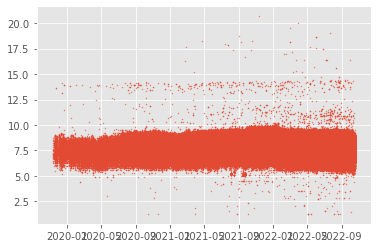

In [7]:
date_column = oam["CREATED_ON_HQ"]
log_rate_column = oam["RATE_USD"].apply(np.log1p)
oam["LOG(RATE_USD)"] = log_rate_column
_ = plt.scatter(date_column, log_rate_column,alpha=0.5, s=1)

In [8]:
oam_groupby_reference_rate_usd =  oam.groupby(["REFERENCE_NUMBER"])["LOG(RATE_USD)"]

In [9]:
groupwise_means = oam_groupby_reference_rate_usd.transform(np.mean)
groupwise_stdevs = oam_groupby_reference_rate_usd.transform(lambda x: np.std(x,ddof=0))

In [16]:
zscore_rate_usd_column = ((oam["LOG(RATE_USD)"] - groupwise_means)/groupwise_stdevs)
zscore_rate_usd_column = zscore_rate_usd_column.fillna(0) # imput zero division errors with 0 (for single-offer orders)

In [17]:
oam["zscore(RATE_USD)"] = zscore_rate_usd_column

In [18]:
binarized_zscore_rate_usd_column = (zscore_rate_usd_column > 0).astype(int)

oam["zscore(RATE_USD)>0"] = binarized_zscore_rate_usd_column

In [32]:
from scipy.stats import percentileofscore
def get_percentiles(arr):
    sorted_arr = sorted(arr)
    f = lambda x: percentileofscore(sorted_arr,x)
    return list(map(f, arr))
groupwise_percentiles = oam_groupby_reference_rate_usd.transform(get_percentiles)

In [35]:
oam["PERCENTILE(RATE_USD)"] = groupwise_percentiles

In [41]:
# Questions: 
# which carriers will try to do a 2nd chance?
# given the time, what is rate usd?

In [59]:
business_days = [0,1,2,3,4]
# Day 0 is Monday
days_range = business_days
business_day_names = ["Monday","Tuesday","Wednesday","Thursday","Friday"]

In [48]:
oam["MONTH"] = oam["CREATED_ON_HQ"].dt.month
oam["DAY_OF_WEEK"] = oam["CREATED_ON_HQ"].dt.dayofweek
oam["DAYNAME_OF_WEEK"] = oam["CREATED_ON_HQ"].dt.day_name()

Ranking Weekdays' (Groupwise)
Argmin is on Thursday


DAYNAME_OF_WEEK
Friday       0.451306
Monday       0.454253
Thursday     0.448788
Tuesday      0.453000
Wednesday    0.455491
Name: zscore(RATE_USD)>0, dtype: float64

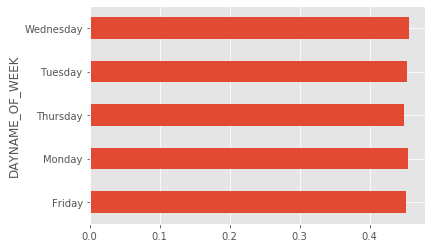

In [55]:
print("Ranking Weekdays' (Groupwise)")

business_days_groupby = (oam[oam["DAY_OF_WEEK"].isin(days_range)]).groupby(["DAYNAME_OF_WEEK"])

business_days_by_mean_binarized_zscore_log_rate_usd = business_days_groupby["zscore(RATE_USD)>0"].mean()
print("Argmin is on",
      business_days_by_mean_binarized_zscore_log_rate_usd.idxmin()
)
business_days_by_mean_binarized_zscore_log_rate_usd.plot.barh()
business_days_by_mean_binarized_zscore_log_rate_usd

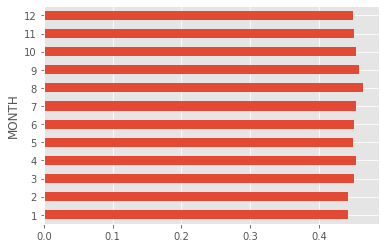

In [43]:
oam.groupby(["MONTH"])["zscore(RATE_USD)>0"].mean().plot.barh()

Argmin is on Thursday


DAYNAME_OF_WEEK
Friday       61.796184
Monday       61.053309
Thursday     60.968710
Tuesday      61.049899
Wednesday    61.273539
Name: PERCENTILE(RATE_USD), dtype: float64

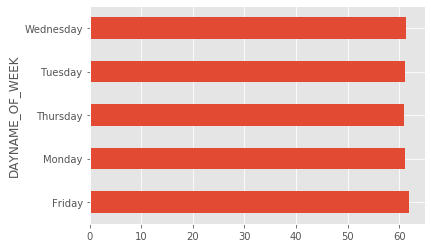

In [54]:
print("Ranking Weekdays' (Percentile)")
business_days_groupby = (oam[oam["DAY_OF_WEEK"].isin(days_range)]).groupby(["DAYNAME_OF_WEEK"])

business_days_by_mean_binarized_zscore_log_rate_usd = business_days_groupby["PERCENTILE(RATE_USD)"].mean()
print("Argmin is on",
      business_days_by_mean_binarized_zscore_log_rate_usd.idxmin()
)
business_days_by_mean_binarized_zscore_log_rate_usd.plot.barh()
business_days_by_mean_binarized_zscore_log_rate_usd

In [56]:
from tqdm import tqdm

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|                                                                                          | 0/500 [00:00<?, ?it/s]c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00

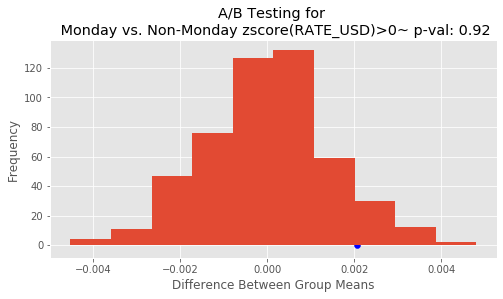

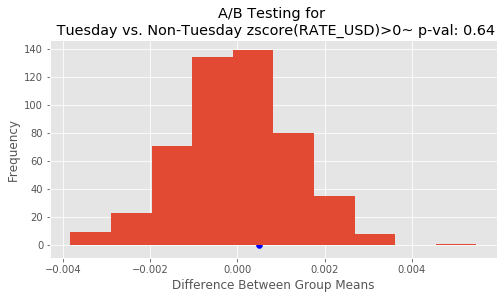

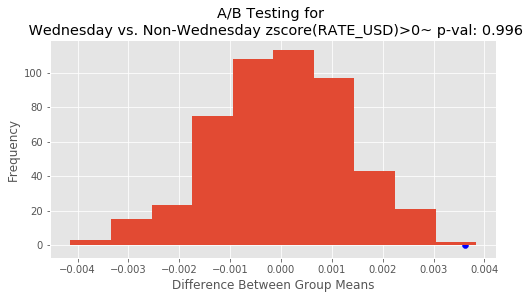

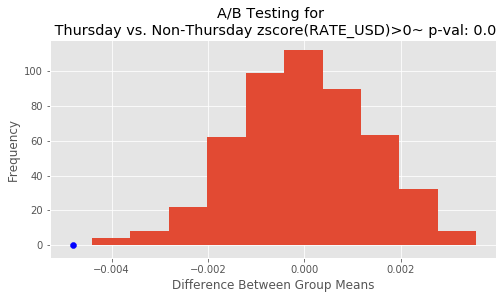

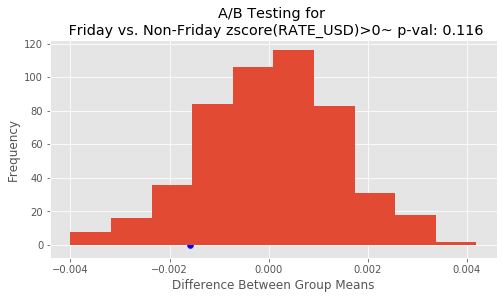

In [61]:
def ABTesting_Borough_Traffic(
    TABLE,
    BORO,
    GROUPBY_COLUMN_NAME,
    AGGREG_COLUMN_NAME
):
    #nyc_traffic_EDA_temp = oam[oam["DAY_OF_WEEK"].isin(business_days)]
    BORO_CHOICE = BORO
    #TABLE = nyc_traffic_EDA_temp
    #GROUPBY_COLUMN_NAME = "DAY_OF_WEEK"
   # AGGREG_COLUMN_NAME = "zscore(RATE_USD)>0"
    SHUFFLED_COLUMN_NAME = GROUPBY_COLUMN_NAME
    #SHUFFLED_COLUMN_NAME = AGGREG_COLUMN_NAME
    SHUFFLED_COLUMN = TABLE[SHUFFLED_COLUMN_NAME].values
    AB_TESTING_PLOT_TITLE = "A/B Testing for \n {0} vs. Non-{0} {1}".format(BORO_CHOICE, AGGREG_COLUMN_NAME)
    AB_TESTING_PLOT_X_LABEL = "Difference Between Group Means"
    AB_TESTING_PLOT_Y_LABEL = "Frequency"

    test_stats = []
    T = 500

    TABLE[GROUPBY_COLUMN_NAME] = (TABLE[GROUPBY_COLUMN_NAME] == BORO_CHOICE)
    SHUFFLED_COLUMN = TABLE[SHUFFLED_COLUMN_NAME].values

    observed_test_stat = TABLE.groupby([GROUPBY_COLUMN_NAME])[AGGREG_COLUMN_NAME].mean().diff().loc[1]

    for i in tqdm(range(T)):
        SHUFFLED_COLUMN = np.random.permutation(SHUFFLED_COLUMN)
        # shuffle
        TABLE[SHUFFLED_COLUMN_NAME] = SHUFFLED_COLUMN
        # re-assign
        #print(len(TABLE.groupby([GROUPBY_COLUMN_NAME])[AGGREG_COLUMN_NAME].mean()))
        test_stat = TABLE.groupby([GROUPBY_COLUMN_NAME])[AGGREG_COLUMN_NAME].mean().diff().loc[1]
        test_stats.append(test_stat)
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(test_stats)
    ax.set_title(AB_TESTING_PLOT_TITLE  + "~ p-val: {0}".format(str((np.array(test_stats) < (observed_test_stat)).mean())))
    ax.set_xlabel(AB_TESTING_PLOT_X_LABEL)
    ax.set_ylabel(AB_TESTING_PLOT_Y_LABEL)
    
    ax.scatter(observed_test_stat,0,color="blue")
    return (ax, test_stats, observed_test_stat)

#fig, axs = plt.subplots(len(pd.unique(nyc_traffic_EDA["BoroCode"])), sharex=False, figsize=(8,16))
for day in business_day_names:
    ax, test_stats, observed_test_stat = (
        ABTesting_Borough_Traffic(
            oam[oam["DAY_OF_WEEK"].isin(business_days)],
            day,
            "DAYNAME_OF_WEEK",
            "zscore(RATE_USD)>0"
        )
    )

**Thursday is the odd one out with a very small p-value**

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|                                                                                          | 0/500 [00:00<?, ?it/s]c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00

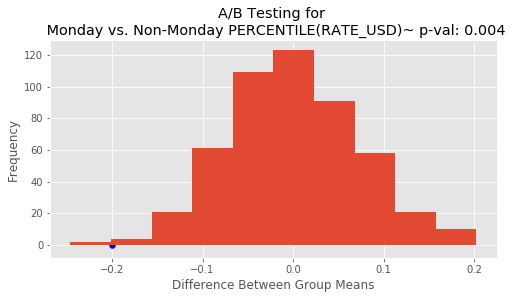

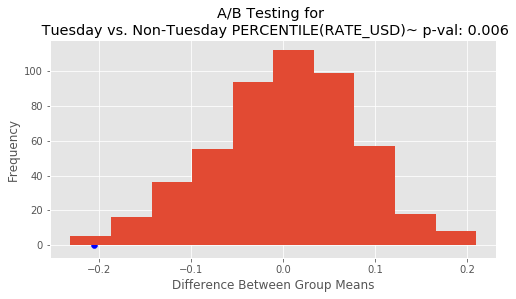

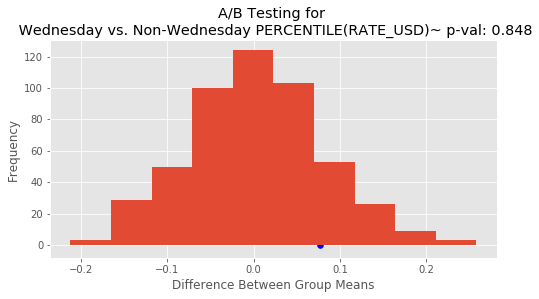

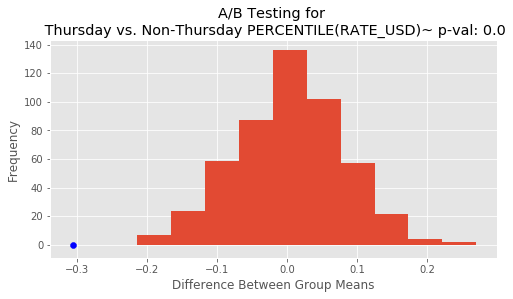

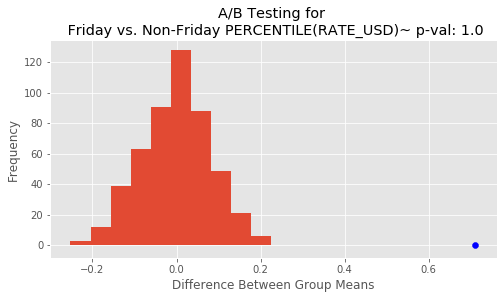

In [62]:
#  Repeating the same thing for Percentile
for day in business_day_names:
    ax, test_stats, observed_test_stat = (
        ABTesting_Borough_Traffic(
            oam[oam["DAY_OF_WEEK"].isin(business_days)],
            day,
            "DAYNAME_OF_WEEK",
            "PERCENTILE(RATE_USD)"
        )
    )

### ANOVA Testing with Total Variation Distance:
* Hypothesis Testing to test any relations between rate and day of week will use ANOVA.
* Null Hypothesis: The group-wise rates means per day of week are the same, and any differences are just due to chance.
* Alternative Hypothesis: The distribution of rate means are unequal
* Result: A very low p-value (less than 0.05) shows the Null Hypothesis is rejected.
* If we want to use ANOVA, we need to check assumptions: We can assume that the data is sampled randomly and independent
* But is the normality assumption passed?

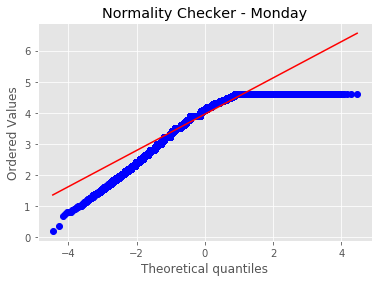

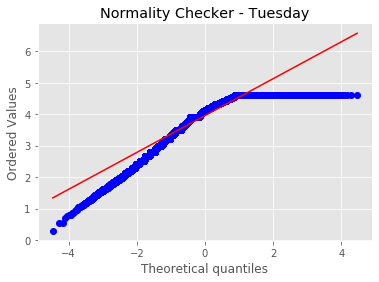

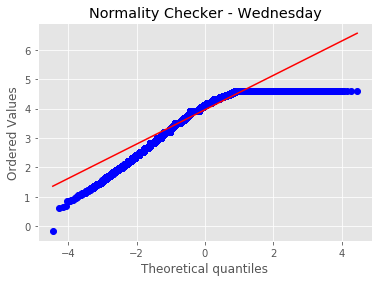

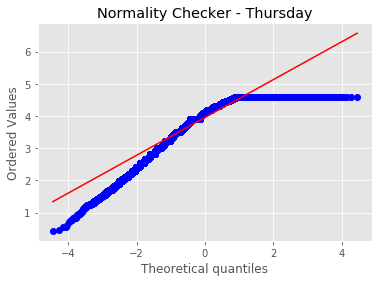

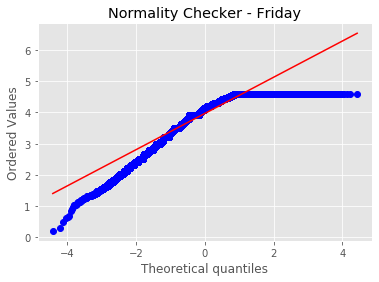

In [73]:
import scipy.stats as stats
for day in business_day_names:
    stats.probplot(oam[oam['DAYNAME_OF_WEEK'] == day]['PERCENTILE(RATE_USD)'].apply(np.log), dist="norm", plot=plt)
    plt.title("Normality Checker - " +  str(day))
    plt.show()

* Normality is proven. 
* Now checking the Assumption for Homogeneity of Variance. The Max Stdev-Min StDev ratio is 1.07, so it is adequately homogeneous.


In [75]:
# get the ratio of the largest to the smallest sample standard deviation
max_min_stdev_ratio = (
    (oam.groupby(["DAY_OF_WEEK"])["PERCENTILE(RATE_USD)"].std().max()
    ) / (
        oam.groupby(["DAY_OF_WEEK"])["PERCENTILE(RATE_USD)"].std().min())
    )
print(max_min_stdev_ratio)

1.0262317653749764


* Looking into Homogeneousness
* After this, check to see if statistically significant thursday

In [76]:
from scipy.stats import stats

day_i_rates = [oam[oam['DAYNAME_OF_WEEK']==day]["PERCENTILE(RATE_USD)"] for day in business_day_names]

anova_results = stats.f_oneway(*day_i_rates)
f_stat, p_value = anova_results
print("F-stat:   {0}".format(f_stat))
print("P-value:   {0}".format(p_value))

F-stat:   21.01117031735577
P-value:   2.4238996311929482e-17


### Chi Square Test

In [78]:
oam1 = oam[oam["DAYNAME_OF_WEEK"].isin(business_day_names)]
contigency_table = (
    pd.crosstab(oam1['zscore(RATE_USD)>0'],
                oam1['DAYNAME_OF_WEEK'], 
                margins = False)
)

In [80]:
from scipy.stats import chi2_contingency
  
# defining the table
data = [[207, 282, 241], [234, 242, 232]]
stat, p, dof, expected = chi2_contingency(contigency_table.values)
  
# interpret p-value
alpha = 0.05
print("p value", str(p))

p value 0.001037492858802938
